<a href="https://colab.research.google.com/github/tupoylogin/AlgoTradingSandbox/blob/main/PortfolioOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import re
from io import StringIO
from datetime import datetime, timedelta
from collections import defaultdict
import typing as tp
import time
from itertools import combinations

from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter

sns.set()

## Choosing a stock range

In [14]:
STOCKS = ['AAPL', 'AMZN', 'GOOGL','FB', 'T', 'VZ', 'MCD', 'IBM', 'CSCO', 'JPM', '^GSPC'] #^GSPC is a symbol for S&P500
# risk free rate is taken from US Daily Treasury Bill Rates Data: 
# https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=billRatesYear&year=2021
RISK_FREE_RATE = 0.1/100 

In [15]:
class StockParser:
    """
    Retrieves stock data by its symbol
    """
    timeout = 2
    crumb_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1d&events=history&crumb={crumb}'

    def __init__(self, symbol: str, days_back: int = 7):
        self.symbol = symbol
        self.session = requests.Session()
        self.dt = timedelta(days=days_back)

    def get_crumb(self):
        response = self.session.get(self.crumb_link.format(self.symbol), timeout=self.timeout)
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError('Could not get crumb from Yahoo Finance')
        else:
            self.crumb = match.group(1)

    def get_quote(self, leave_cols: tp.List[str] = None) -> pd.DataFrame:
        if not hasattr(self, 'crumb') or len(self.session.cookies) == 0:
            self.get_crumb()
        now = datetime.utcnow()
        dateto = int(now.timestamp())
        datefrom = int((now - self.dt).timestamp())
        url = self.quote_link.format(quote=self.symbol, dfrom=datefrom, dto=dateto, crumb=self.crumb)
        response = self.session.get(url)
        response.raise_for_status()
        data = pd.read_csv(StringIO(response.text), parse_dates=['Date'])
        if leave_cols:
          return data[leave_cols]
        return data

In [16]:
STOCK_DATA = defaultdict(str)
for stock in STOCKS:
    data = StockParser(stock, days_back=365).get_quote(leave_cols=['Date', 'Close'])
    STOCK_DATA[stock] = data
    time.sleep(1.5)

## Let's visualize the return-volatility distribution among all stocks

In [5]:
%matplotlib inline

def simple_ret_vol(stock: pd.DataFrame):
    index_return = stock['Close'].pct_change()[1:].tolist()
    return np.mean(index_return), np.std(index_return)

def visualize_ret_vol(ax, stock_data: tp.Dict[str, pd.DataFrame]):
    for k, v in stock_data.items():
        retvol = simple_ret_vol(v)
        ax.scatter(*retvol)
        ax.annotate(k, retvol, xytext=(10,0), textcoords='offset points')

def visualize_ret_vol_2(ax, stock_data: tp.Dict[str, tp.Tuple[float]]):
    for k, retvol in stock_data.items():
        ax.scatter(*retvol)
        ax.annotate(k, retvol, xytext=(10,0), textcoords='offset points')
    

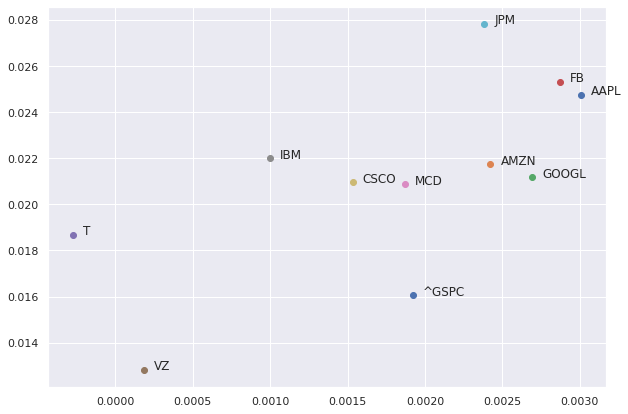

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
visualize_ret_vol(ax, STOCK_DATA)
fig.show()

In [18]:
pd.DataFrame([[sname, *simple_ret_vol(sdata)] for sname, sdata in STOCK_DATA.items()], 
             columns=['asset', 'return', 'volatility'])

,asset,return,volatility
0,AAPL,0.003006,0.024766
1,AMZN,0.002423,0.021737
2,GOOGL,0.002693,0.021181
3,FB,0.002870,0.025317
4,T,-0.000272,0.018676
5,VZ,0.000185,0.012811
6,MCD,0.001868,0.020866
7,IBM,0.000998,0.021996
8,CSCO,0.001533,0.020955
9,JPM,0.002382,0.027825


In [19]:
index_mean_return, index_std_return = simple_ret_vol(STOCK_DATA[STOCKS[-1]])

## Creating a random asset combinations

In [20]:
possible_portfolios = list(map(lambda x: (STOCKS[-1], *x), combinations(STOCKS[:-1], 2)))
rc = np.random.choice(len(possible_portfolios), 4)
possible_portfolios = np.array(possible_portfolios)[rc]

## Defining an asset structure optimizer. 
###It's a simple tool that solves convex optimization problem based on two options - should we minimise total asset volatility or should we maximise Sharpe ratio

In [21]:
class PortfolioOptimizer(object):
    def __init__(self, stocks: tp.Tuple[str],
        ) -> None:

        self._coins = stocks
        self._coin_history = self._fetch_all(stocks)

    @staticmethod
    def _fetch_all(stocks: tp.List[str]):
        coin_history = {}

        def index_history(hist: pd.DataFrame) -> pd.DataFrame:
            # index by date so we can easily filter by a given timeframe
            hist = hist.set_index('Date')
            hist.index = pd.to_datetime(hist.index, unit='d')
            return hist

        def fetch_history(coin: str) -> pd.DataFrame:
            hist = STOCK_DATA[coin]
            hist = index_history(hist)
            return hist

        for coin in stocks:
            coin_history[coin] = fetch_history(coin)
        return coin_history

    @staticmethod
    def get_all_returns(stocks: tp.List[str], history: pd.DataFrame):
        average_returns = defaultdict(str)
        cumulative_returns = defaultdict(str)
        coin_history = history.copy()
        for coin in stocks:
            hist = coin_history[coin]
            hist['return'] = hist['Close'].pct_change().fillna(0.)
            average = hist["return"].mean()
            average_returns[coin] = average
            cumulative_returns[coin] = (hist["return"] + 1).prod() - 1
            hist['excess_return'] = hist['return'] - average
            coin_history[coin] = hist
        return coin_history, average_returns, cumulative_returns
    
    @staticmethod
    def get_excess_matrix(hist_length: int, history: pd.DataFrame, coins: tp.Tuple[str]):
        excess_matrix = np.zeros((hist_length, len(coins)))
        coin_history = history.copy()
        for i in range(0, hist_length):
            for idx, coin in enumerate(coins):
                excess_matrix[i][idx] = coin_history[coin].iloc[i]['excess_return']
        return excess_matrix
    
    @staticmethod
    def get_varcovar_matrix(excess_matrix: np.ndarray, hist_length: int):
        product_matrix = np.matmul(excess_matrix.T, excess_matrix)
        var_covar_matrix = product_matrix / hist_length
        return var_covar_matrix
    
    @staticmethod
    def get_stddev_matrix(coins: tp.List[str], history: pd.DataFrame):
        coin_history = history.copy()
        std_deviations = np.zeros((len(coins), 1))
        for idx, coin in enumerate(coins):
            std_deviations[idx][0] = np.std(coin_history[coin]['return'])
        return std_deviations
    
    @staticmethod
    def get_corr_matrix(std_deviations: np.ndarray, varcovar: np.ndarray):
        sdev_product = np.matmul(std_deviations, std_deviations.T)
        correlation_matrix = varcovar / sdev_product
        return correlation_matrix
    
    def train_test_split(self):
        train, test = {}, {}
        for k, v in self._coin_history.items():
            train.update({k: v.iloc[:-100, :]})
            test.update({k: v.iloc[-100:, :]})
        return train, test
    
    @staticmethod
    def get_asset_shares(weights, history):
        asset = pd.DataFrame(index=history[list(weights.keys())[0]].index)
        asset['close'] = np.sum([(history[k]['Close']*v).values for k,v in weights.items()], axis=0)
        return asset
    
    def optimize(self, desired_annualy_rate: float, objective: str = 'volatility'):
        mu = desired_annualy_rate
        train = self._coin_history
        hist_len = len(train[self._coins[0]])
        history, average_returns, cumulative_returns = self.get_all_returns(self._coins, train)
        std_deviations = self.get_stddev_matrix(self._coins, history)
        excess_matrix = self.get_excess_matrix(hist_len, history, self._coins)
        var_covar_matrix = self.get_varcovar_matrix(excess_matrix, hist_len)
        correlation_matrix = self.get_corr_matrix(std_deviations, var_covar_matrix)
        coins = self._coins
        run = True

        def volatility(coin_weights: np.ndarray,
                       std_deviations: np.ndarray, 
                       correlation_matrix: np.ndarray):
            weighted_std_devs = coin_weights.reshape(-1,1) * std_deviations
            product_1 = weighted_std_devs
            product_2 = np.matmul(correlation_matrix, product_1)
            portfolio_variance = product_2 * weighted_std_devs
            portfolio_volatility = np.sqrt(np.sum(portfolio_variance))
            return portfolio_volatility

        def neg_sharpe(coin_weights: np.ndarray,
                       std_deviations: np.ndarray, 
                       correlation_matrix: np.ndarray):
            portfolio_volatility = volatility(coin_weights,
                                              std_deviations, 
                                          correlation_matrix)
            portfolio_return = np.dot(coin_weights, returns)   
            sharpe_ratio = (portfolio_return - RISK_FREE_RATE)/portfolio_volatility
            return -1*sharpe_ratio

        returns = np.array(list(average_returns.values()))
        x0 = np.array(len(coins)*[1./len(coins)])
        
        bounds = tuple([(0., 1.) for _ in range(len(coins))])
        constraints = ({'type': 'eq',
                'fun' : lambda x: np.sum(x) - 1.},
                {'type': 'eq',
                'fun' : lambda x: np.sum(returns*x) - mu,
                'jac' : lambda x: returns}
                        )
        if objective == 'volatility':
            func_to_min = volatility
        elif objective == 'sharpe':
            func_to_min = neg_sharpe
        res = minimize(func_to_min, x0, method='SLSQP', 
                        constraints=constraints, tol=1e-6, bounds=bounds,
                        args=(std_deviations, correlation_matrix)
                        )
        x = zip(coins, res.x)
        x = dict(filter(lambda x: x[-1]>0, x))
        coins = list(x.keys())
        results_weights = {'asset': list(x.keys()), 'ratio': list(x.values())}
        asset = self.get_asset_shares(x, train)
        asset_stats = {'return': [asset.close.pct_change().mean()], 
                       'volatility': [asset.close.pct_change().std()]}
        return results_weights, asset_stats

### Minimizing total volatility

In [24]:
portfolios = defaultdict(str)
for triple in possible_portfolios:
  print('='*25)
  print(f'Calculating stats for portfolio {", ".join(triple)}')
  popt = PortfolioOptimizer(triple)
  weights, stats = popt.optimize(index_mean_return, objective='volatility')
  print(f'Weights of each asset\n{pd.DataFrame(weights).set_index("asset")}')
  print('*'*25)
  print(f'Stats for portfolio\n{pd.DataFrame(stats)}')
  portfolio_name = '+'.join(['*'.join([str(np.round(vi, 3)), ki]) for ki, vi in zip(*weights.values())])
  portfolios[portfolio_name] = tuple(list(map(sum, stats.values())))

Calculating stats for portfolio ^GSPC, GOOGL, IBM
Weights of each asset
          ratio
asset          
^GSPC  0.990097
GOOGL  0.009903
*************************
Stats for portfolio
     return  volatility
0  0.001926    0.016081
Calculating stats for portfolio ^GSPC, IBM, CSCO
Weights of each asset
              ratio
asset              
^GSPC  1.000000e+00
IBM    2.275960e-15
*************************
Stats for portfolio
     return  volatility
0  0.001923    0.016081
Calculating stats for portfolio ^GSPC, AAPL, JPM
Weights of each asset
              ratio
asset              
^GSPC  9.929562e-01
AAPL   7.043761e-03
JPM    1.517883e-18
*************************
Stats for portfolio
     return  volatility
0  0.001923    0.016081
Calculating stats for portfolio ^GSPC, AAPL, CSCO
Weights of each asset
          ratio
asset          
^GSPC  0.926597
AAPL   0.024608
CSCO   0.048795
*************************
Stats for portfolio
     return  volatility
0  0.001923    0.016082


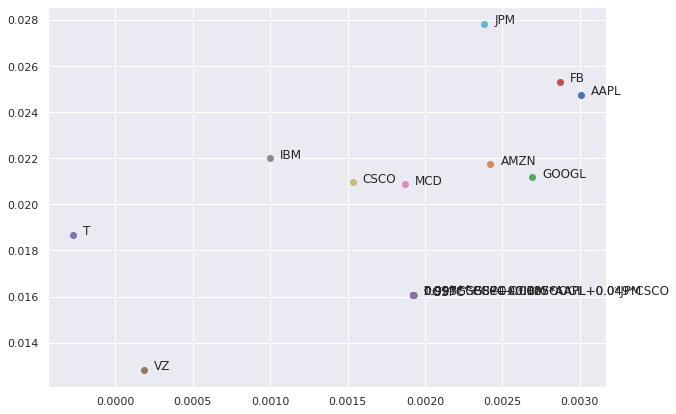

In [25]:
fig, ax = plt.subplots(figsize=(10, 7))
visualize_ret_vol(ax, STOCK_DATA)
visualize_ret_vol_2(ax, portfolios)
fig.show()

### Maximizing Sharpe ratio

In [26]:
portfolios = defaultdict(str)
for triple in possible_portfolios:
  print('='*25)
  print(f'Calculating stats for portfolio {", ".join(triple)}')
  popt = PortfolioOptimizer(triple)
  weights, stats = popt.optimize(index_mean_return, objective='sharpe')
  print(f'Weights of each asset\n{pd.DataFrame(weights).set_index("asset")}')
  print('*'*25)
  print(f'Stats for portfolio\n{pd.DataFrame(stats)}')
  portfolio_name = '+'.join(['*'.join([str(np.round(vi, 3)), ki]) for ki, vi in zip(*weights.values())])
  portfolios[portfolio_name] = tuple(list(map(sum, stats.values())))

Calculating stats for portfolio ^GSPC, GOOGL, IBM
Weights of each asset
              ratio
asset              
^GSPC  9.900968e-01
GOOGL  9.903218e-03
IBM    2.775558e-17
*************************
Stats for portfolio
     return  volatility
0  0.001926    0.016081
Calculating stats for portfolio ^GSPC, IBM, CSCO
Weights of each asset
              ratio
asset              
^GSPC  1.000000e+00
IBM    5.203282e-16
CSCO   2.707668e-14
*************************
Stats for portfolio
     return  volatility
0  0.001923    0.016081
Calculating stats for portfolio ^GSPC, AAPL, JPM
Weights of each asset
              ratio
asset              
^GSPC  9.929562e-01
AAPL   7.043761e-03
JPM    2.602085e-18
*************************
Stats for portfolio
     return  volatility
0  0.001923    0.016081
Calculating stats for portfolio ^GSPC, AAPL, CSCO
Weights of each asset
          ratio
asset          
^GSPC  0.923137
AAPL   0.025524
CSCO   0.051340
*************************
Stats for portfolio
     r

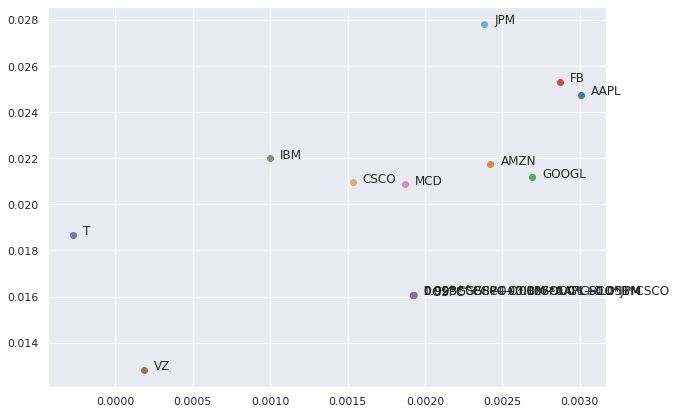

In [27]:
fig, ax = plt.subplots(figsize=(10, 7))
visualize_ret_vol(ax, STOCK_DATA)
visualize_ret_vol_2(ax, portfolios)
fig.show()

##Conclusions
### As we can see, the results are pretty much the same and our portfolios tends to have the same volatility and expected return as S&P500 index. That is because we manipulating both index and stocks which are included in that index.